In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import os.path
from loguru import logger
import seaborn as sns
import statsmodels.formula.api as sm
from utils import get_human_timestamp


import plotly.graph_objects as go
import datetime
import vaex
from utils import get_human_timestamp
import warnings
from SABR import SABR
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
import h5py



In [11]:
def find_beta_for_expiration(single_expiration: pd.DataFrame, filter_timestamp=None):
    # if filter_timestamp is given, build regression only on data before that timestamp
    if filter_timestamp:
        single_expiration = single_expiration[
            single_expiration["timestamp"] <= filter_timestamp
        ]

    def get_closest(given_strikes, underlying_price):
        """Finds between which values the given onw lies"""
        # given_strikes sorted
        for index in range(0, len(given_strikes) - 1):
            if (
                given_strikes[index] <= underlying_price
                and given_strikes[index + 1] >= underlying_price
            ):
                return given_strikes[index], given_strikes[index + 1]

    def get_mid_mark_iv(forward: float):
        closest_strikes = get_closest(all_covered_strikes, forward)
        return closest_strikes

    available_strikes = sorted(single_expiration.strike_price.unique())
    max_value_of_underlying = single_expiration.underlying_price.max()
    min_value_of_underlying = single_expiration.underlying_price.min()

    # find between which strikes do max and min forward values are
    right_border = get_closest(available_strikes, max_value_of_underlying)[1]
    left_border = get_closest(available_strikes, min_value_of_underlying)[0]
    all_covered_strikes = [
        strike
        for strike in available_strikes
        if strike >= left_border and strike <= right_border
    ]

    # find between whick strikes one current tick the forward is
    single_expiration["closest_strikes"] = single_expiration["underlying_price"].apply(
        get_mid_mark_iv
    )
    # make borders as columns
    single_expiration["left_border"] = single_expiration["closest_strikes"].apply(
        lambda x: x[0]
    )
    single_expiration["right_border"] = single_expiration["closest_strikes"].apply(
        lambda x: x[1]
    )

    # ticks of only crossed strikes
    df_of_only_needed_strikes = single_expiration[
        single_expiration["strike_price"].isin(all_covered_strikes)
    ]
    df_of_only_needed_strikes = (
        df_of_only_needed_strikes[["timestamp", "strike_price", "mark_iv"]]
        .drop_duplicates()
        .copy()
    )

    # get for all timstamps the values of mark_iv for needed strikes
    df_of_only_needed_strikes_left = df_of_only_needed_strikes.copy()
    df_of_only_needed_strikes_left = df_of_only_needed_strikes_left.rename(
        columns={"mark_iv": "mark_iv_left"}
    )
    single_expiration = single_expiration.merge(
        df_of_only_needed_strikes_left,
        how="left",
        left_on=["timestamp", "left_border"],
        right_on=["timestamp", "strike_price"],
    )
    # same for right ordered
    df_of_only_needed_strikes_right = df_of_only_needed_strikes.copy()
    df_of_only_needed_strikes_right = df_of_only_needed_strikes_right.rename(
        columns={"mark_iv": "mark_iv_right"}
    )
    single_expiration = single_expiration.merge(
        df_of_only_needed_strikes_right,
        how="left",
        left_on=["timestamp", "right_border"],
        right_on=["timestamp", "strike_price"],
    )
    # drop useless cols
    single_expiration = single_expiration.drop(
        columns=["strike_price_y", "strike_price"]
    )
    single_expiration = single_expiration.rename(
        columns={"strike_price_x": "strike_price"}
    )
    # if there are no info on mark_iv of given strike for this tick, fill with previous value
#     single_expiration["mark_iv_left"] = single_expiration["mark_iv_left"].fillna(
#         method="ffill"
#     )
#     single_expiration["mark_iv_right"] = single_expiration["mark_iv_right"].fillna(
#         method="ffill"
#     )

    # get no similar by this cols ticks
    only_needed = single_expiration[
        [
            "timestamp",
            "underlying_price",
            "right_border",
            "left_border",
            "mark_iv_left",
            "mark_iv_right",
            "strike_price",
            "mark_iv",
        ]
    ].copy()
    only_needed = only_needed.dropna()
    #     only_needed = only_needed[only_needed["strike_price"].isin(all_covered_strikes)]

    # weight needed vols by distance between forward and closest strikes
    only_needed["ATM_iv"] = only_needed["mark_iv_left"] * (
        only_needed["right_border"] - only_needed["underlying_price"]
    ) / (only_needed["right_border"] - only_needed["left_border"]) + only_needed[
        "mark_iv_right"
    ] * (
        only_needed["underlying_price"] - only_needed["left_border"]
    ) / (
        only_needed["right_border"] - only_needed["left_border"]
    )

    # get logs for regression
    only_needed["ln_underlying_price"] = np.log(only_needed["underlying_price"])
    only_needed["ln_ATM_iv"] = np.log(only_needed["ATM_iv"])
    to_fit = only_needed[["ln_underlying_price", "ln_ATM_iv"]].drop_duplicates().copy()


    lr = LinearRegression()
    lr.fit(to_fit["ln_underlying_price"].values.reshape(-1, 1), to_fit["ln_ATM_iv"])
    k = lr.coef_[0]
    alpha = lr.intercept_
    # from formula
    beta = k + 1
    # just to see the dependency
#     xx = np.linspace(
#         to_fit["ln_underlying_price"].max(), to_fit["ln_underlying_price"].min(), 100
#     )
#     yy = k * xx + alpha
#     plt.scatter(to_fit["ln_underlying_price"], to_fit["ln_ATM_iv"])
#     plt.plot(xx, yy, color="orange")

#     results = sm.ols(formula="ln_ATM_iv~ln_underlying_price", data=to_fit).fit()
#     results.summary()
    beta = max(min(beta, 1.0), 0.0)
    return beta


In [5]:
def select_data(df: pd.DataFrame, before_timestamp = None):
    # get data before given tick
    if before_timestamp:
        df = df[df["timestamp"]<=before_timestamp]
    # take the latest for each expirartion and strike
    data_grouped = data.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    #days before exp
    data_grouped['days'] = (data_grouped['tau'] * 365).astype(int)
    # only not expired
    put = data_grouped[data_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)
    put = put[put["days"] > 0] 
    call = data_grouped[data_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    call = call[call["days"] > 0] 
    return put, call

In [6]:
# just dataset preprocessing
data = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
# work only with eth
currency = "ETH"
data = data[data["symbol"].str.startswith(currency)]
columns = ["symbol", "timestamp", "type", "strike_price", "expiration", "bid_price", 
                   "ask_price", "mark_price", "mark_iv", "underlying_price"]
data = data[columns]
#tau is time before expiration in years
data['tau'] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365

#getting needed date params understandable for human just for comfort
data["human_expiration"] = data["expiration"].apply(get_human_timestamp)
data["human_timestamp"] = data["timestamp"].apply(get_human_timestamp)

K = data.strike_price.values
F = data.underlying_price.values

payoff = np.maximum(F - K, 0.0)
payoff[data.type == 'put'] = np.maximum( K - F, 0.0)[data.type == 'put']
data["payoff"] = payoff

#inverse 
data["inverse_payoff"] =  data["payoff"]/data["underlying_price"]
data['mid_price'] = 0.5 * (data.ask_price + data.bid_price)

In [7]:
# select a moment in dataset on which we want to calibrate 
# on data BEFORE that moment we calibrate beta
data.head()

,symbol,timestamp,type,strike_price,expiration,bid_price,ask_price,mark_price,mark_iv,underlying_price,tau,human_expiration,human_timestamp,payoff,inverse_payoff,mid_price
0,ETH-9DEC22-1400-C,1669852800002000,call,1400,1670572800000000,0.0140,0.0150,0.0146,69.75,1294.5900,0.022831,2022-12-09 11:00:00.000000,2022-12-01 03:00:00.002000,0.0000,0.000000,0.01450
1,ETH-16DEC22-1300-P,1669852800011000,put,1300,1671177600000000,0.0630,0.0650,0.0632,74.51,1294.5233,0.042009,2022-12-16 11:00:00.000000,2022-12-01 03:00:00.011000,5.4767,0.004231,0.06400
2,ETH-16DEC22-1500-C,1669852800010000,call,1500,1671177600000000,0.0135,0.0145,0.0140,73.44,1294.5233,0.042009,2022-12-16 11:00:00.000000,2022-12-01 03:00:00.010000,0.0000,0.000000,0.01400
3,ETH-30DEC22-1400-P,1669852800013000,put,1400,1672387200000000,0.1310,0.1335,0.1325,72.78,1294.2700,0.080365,2022-12-30 11:00:00.000000,2022-12-01 03:00:00.013000,105.7300,0.081691,0.13225
4,ETH-2DEC22-1300-C,1669852800013000,call,1300,1669968000000000,0.0140,0.0150,0.0147,69.18,1294.4500,0.003653,2022-12-02 11:00:00.000000,2022-12-01 03:00:00.013000,0.0000,0.000000,0.01450


In [8]:
# on the last tick
put, call = select_data(data)
days = sorted(list(set(call.days.values)))
print(f"Available days before expiration in frame: {days}") 


Available days before expiration in frame: [1, 7, 14, 21, 28, 56, 84, 119, 210, 301]


2023-02-01 19:20:20.462 | INFO     | SABR:run:119 - Optimal params for T = 1 days: 
            alpha = 47.05, 
            rho = -0.6, 
            volvol = 247.79
            beta = 0.0
2023-02-01 19:20:48.385 | INFO     | SABR:run:119 - Optimal params for T = 7 days: 
            alpha = 29.19, 
            rho = -0.5, 
            volvol = 91.09
            beta = 1.0
2023-02-01 19:21:13.851 | INFO     | SABR:run:119 - Optimal params for T = 14 days: 
            alpha = 75.66, 
            rho = -0.6, 
            volvol = 302.53
            beta = 1.0
2023-02-01 19:21:18.891 | INFO     | SABR:run:119 - Optimal params for T = 21 days: 
            alpha = 100.32, 
            rho = -0.34, 
            volvol = 124.59
            beta = 1.0
2023-02-01 19:21:46.718 | INFO     | SABR:run:119 - Optimal params for T = 28 days: 
            alpha = 10.07, 
            rho = -0.41, 
            volvol = 45.44
            beta = 1.0
2023-02-01 19:22:11.193 | INFO     | SABR:run:119 - Opti

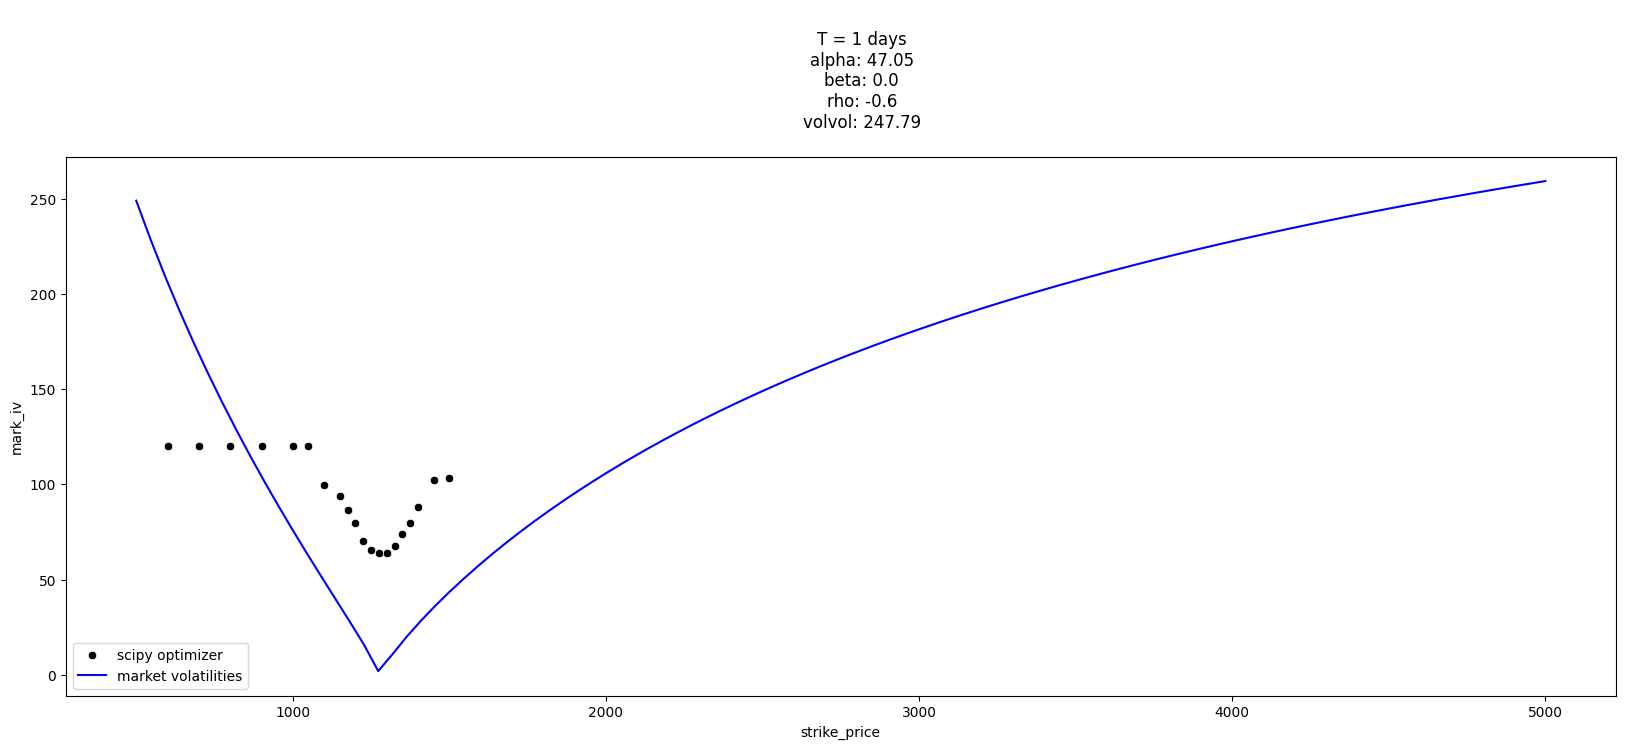

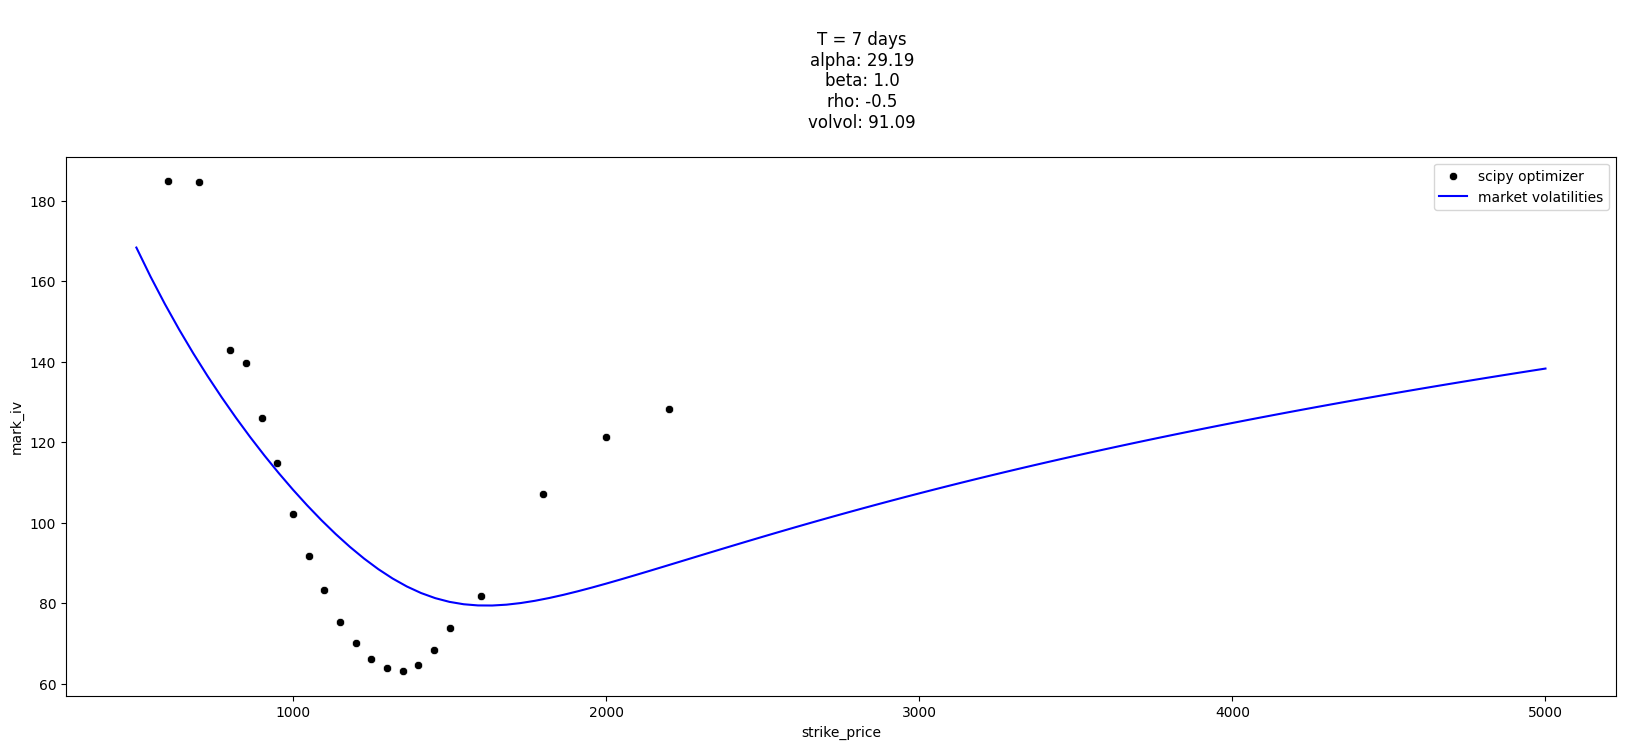

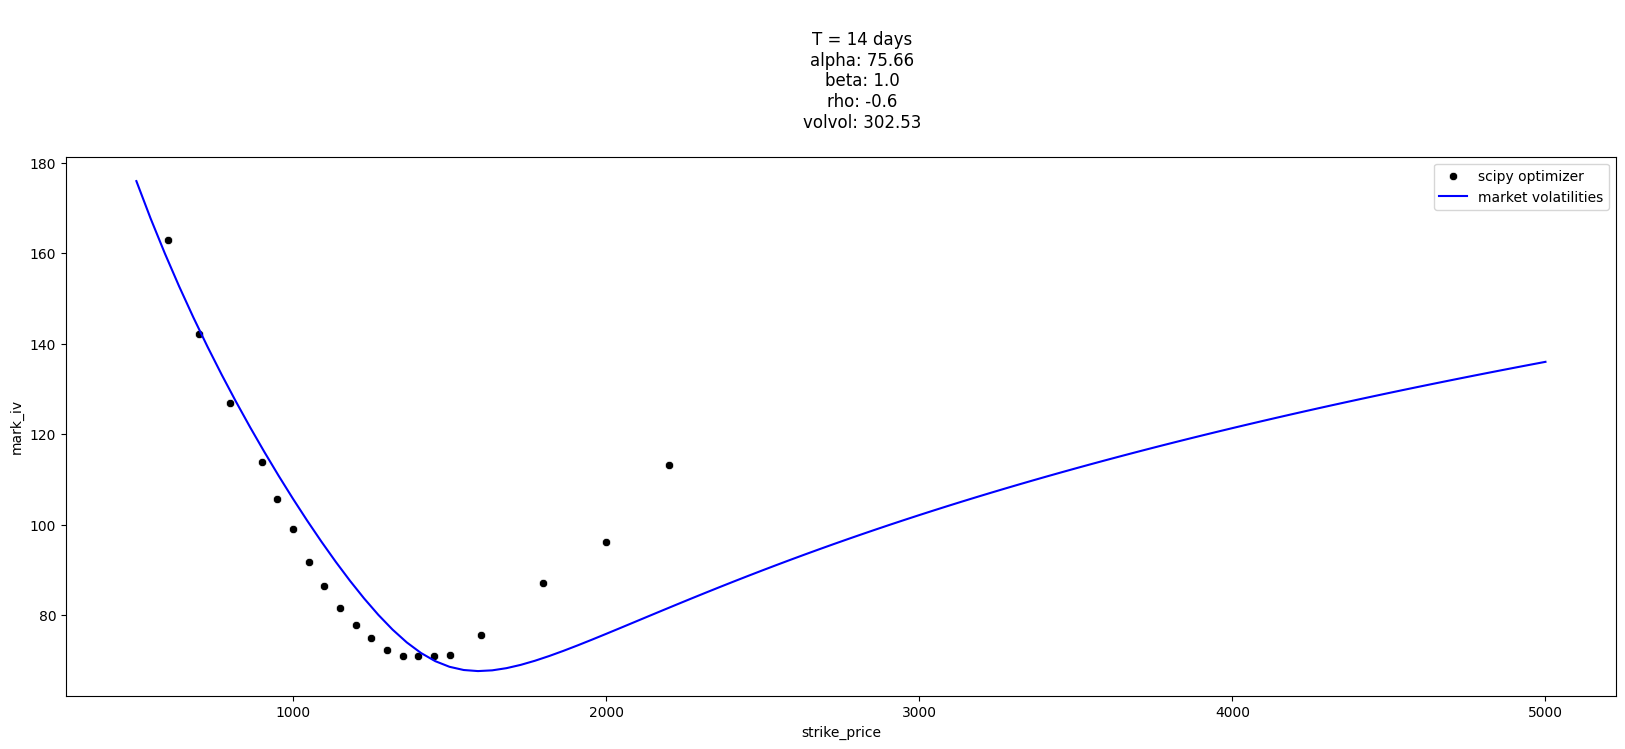

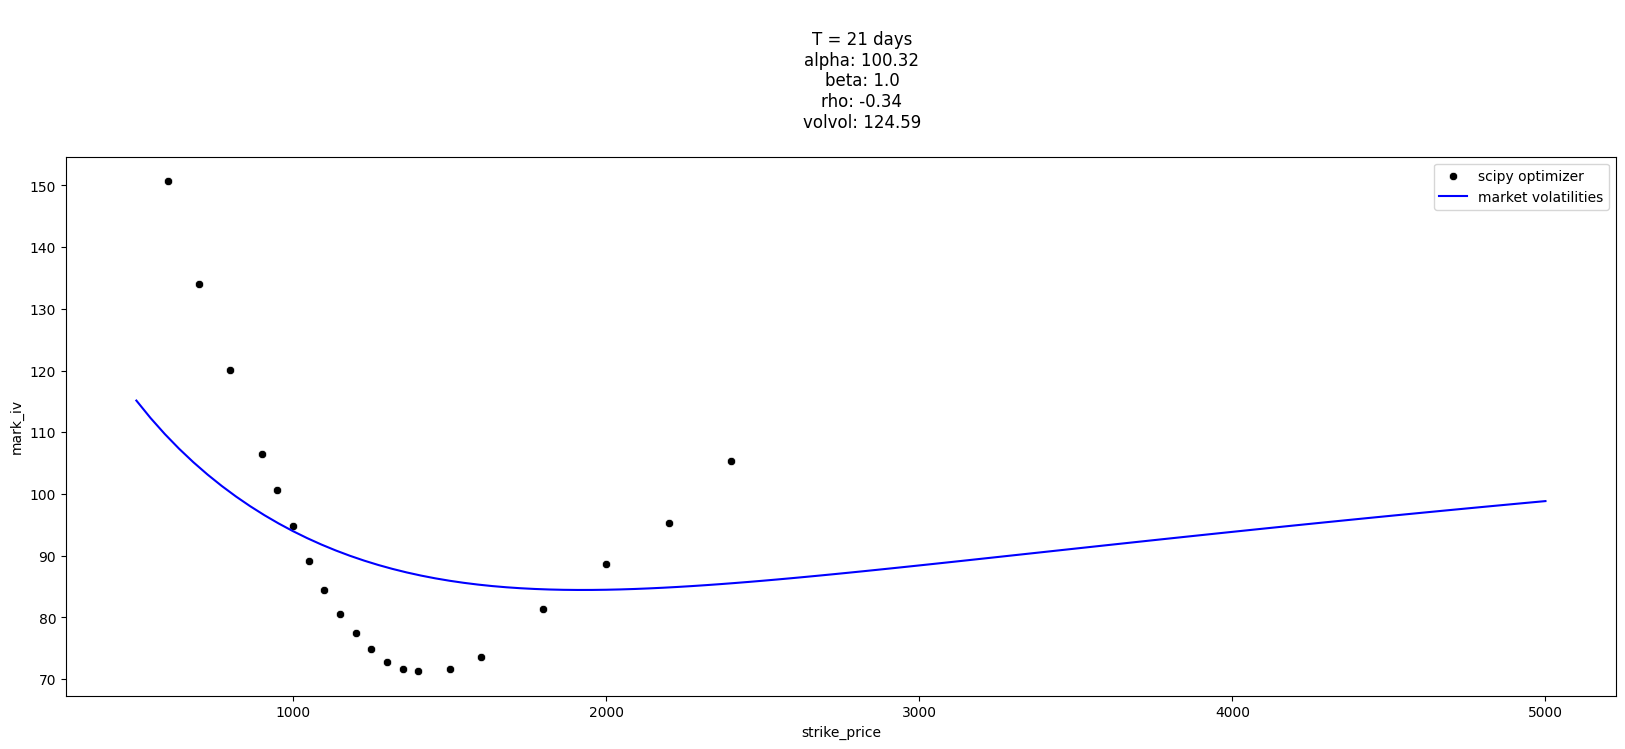

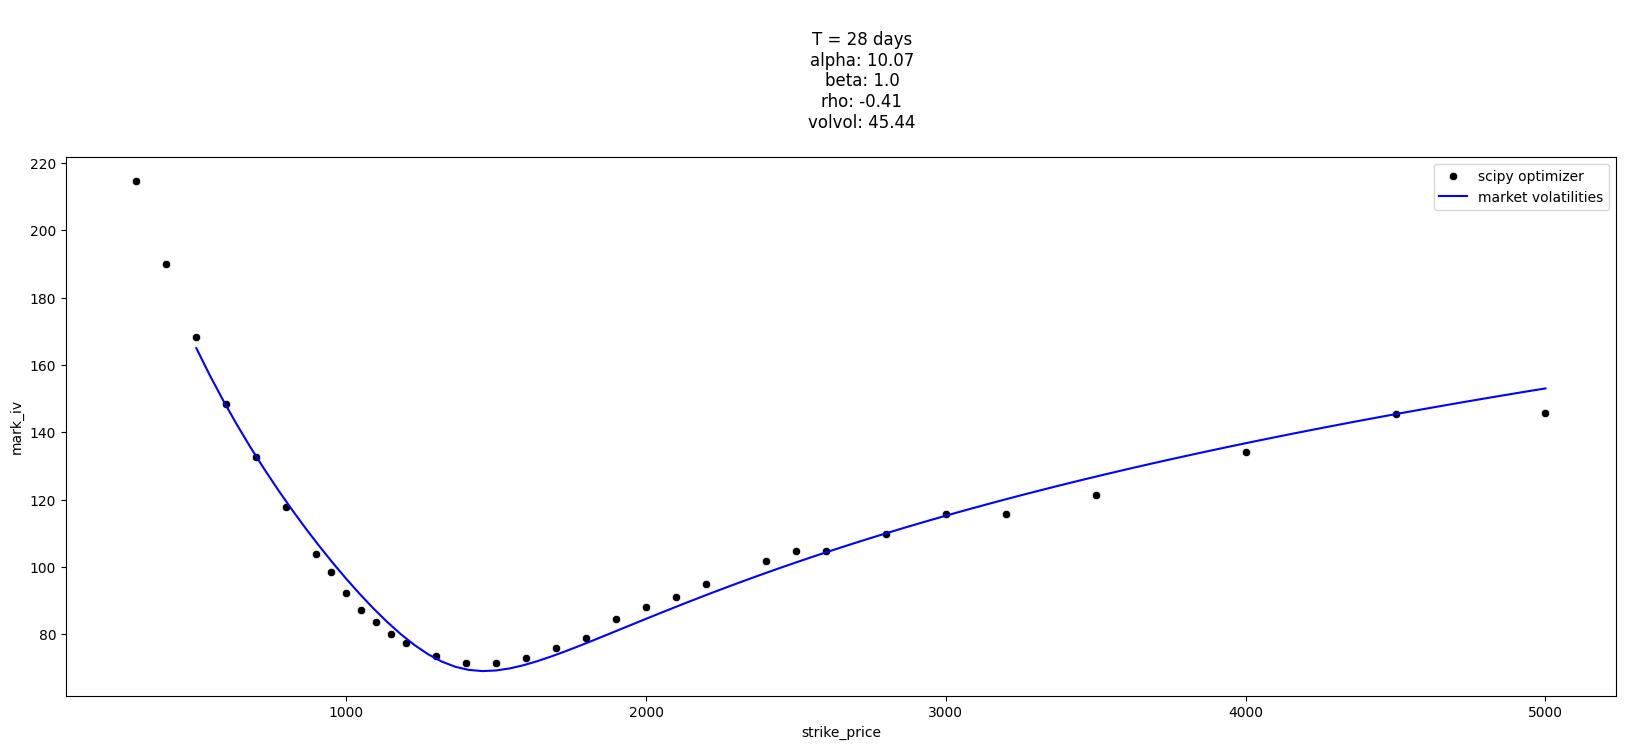

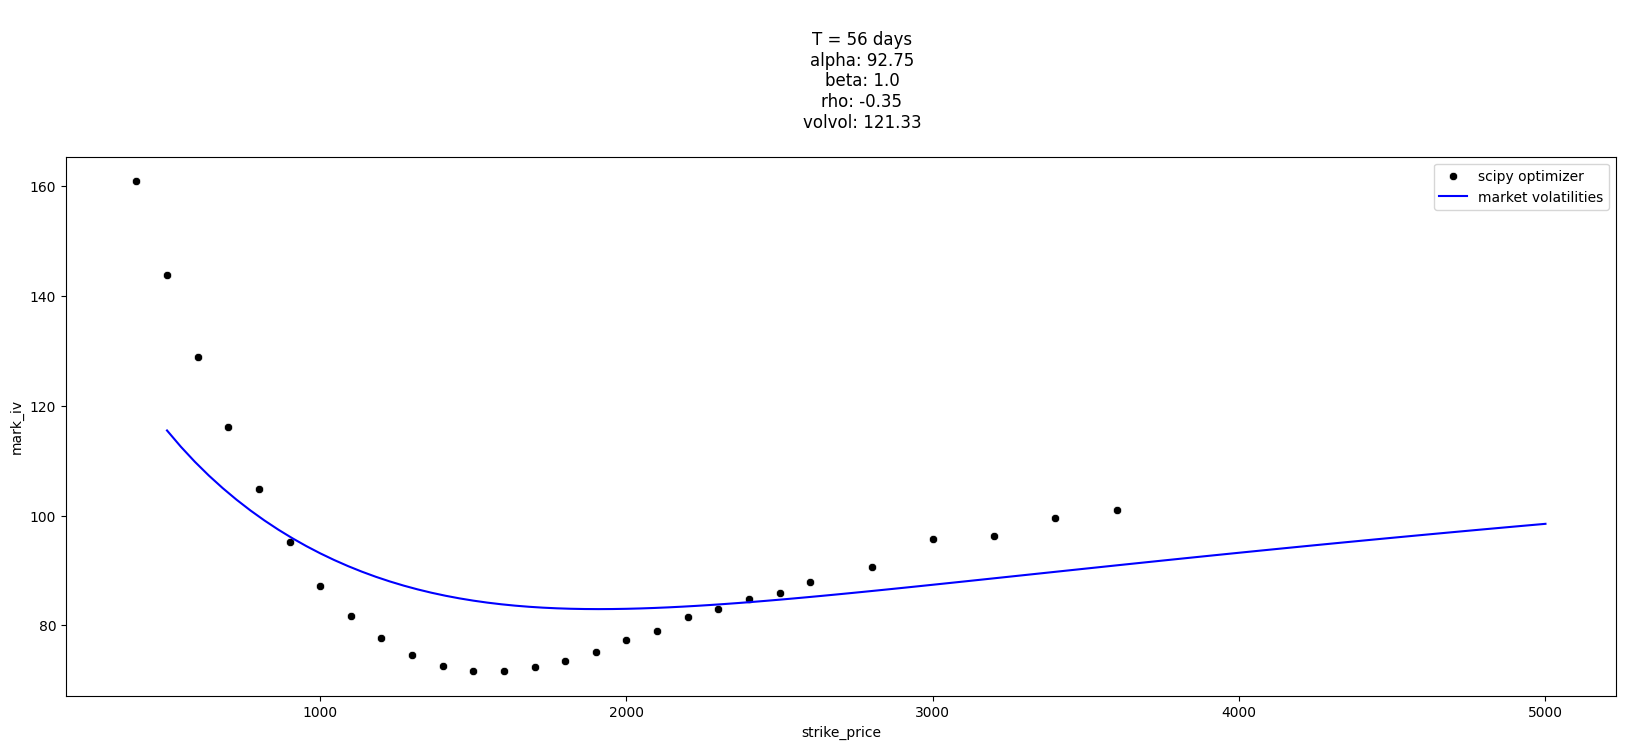

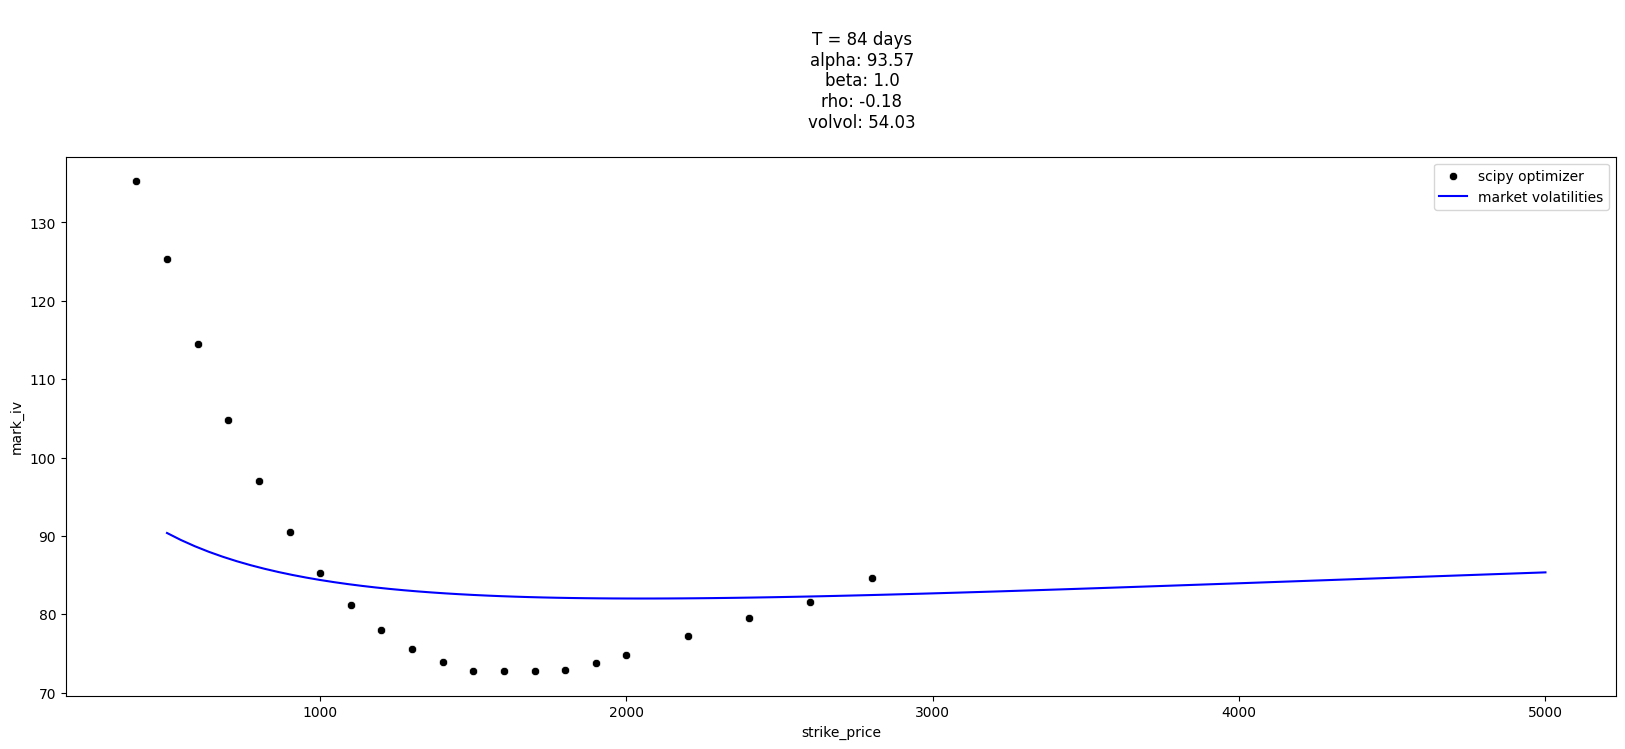

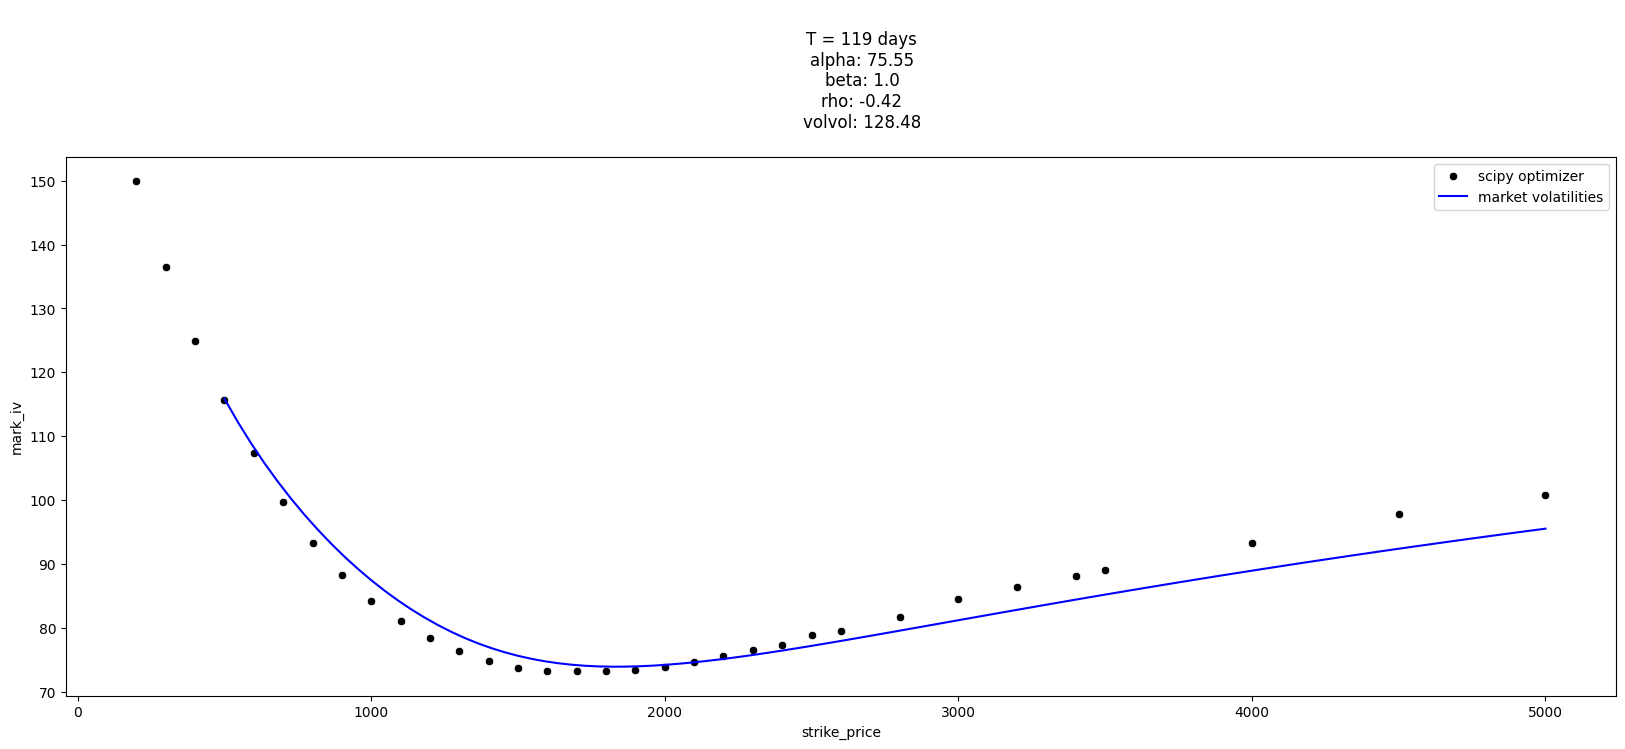

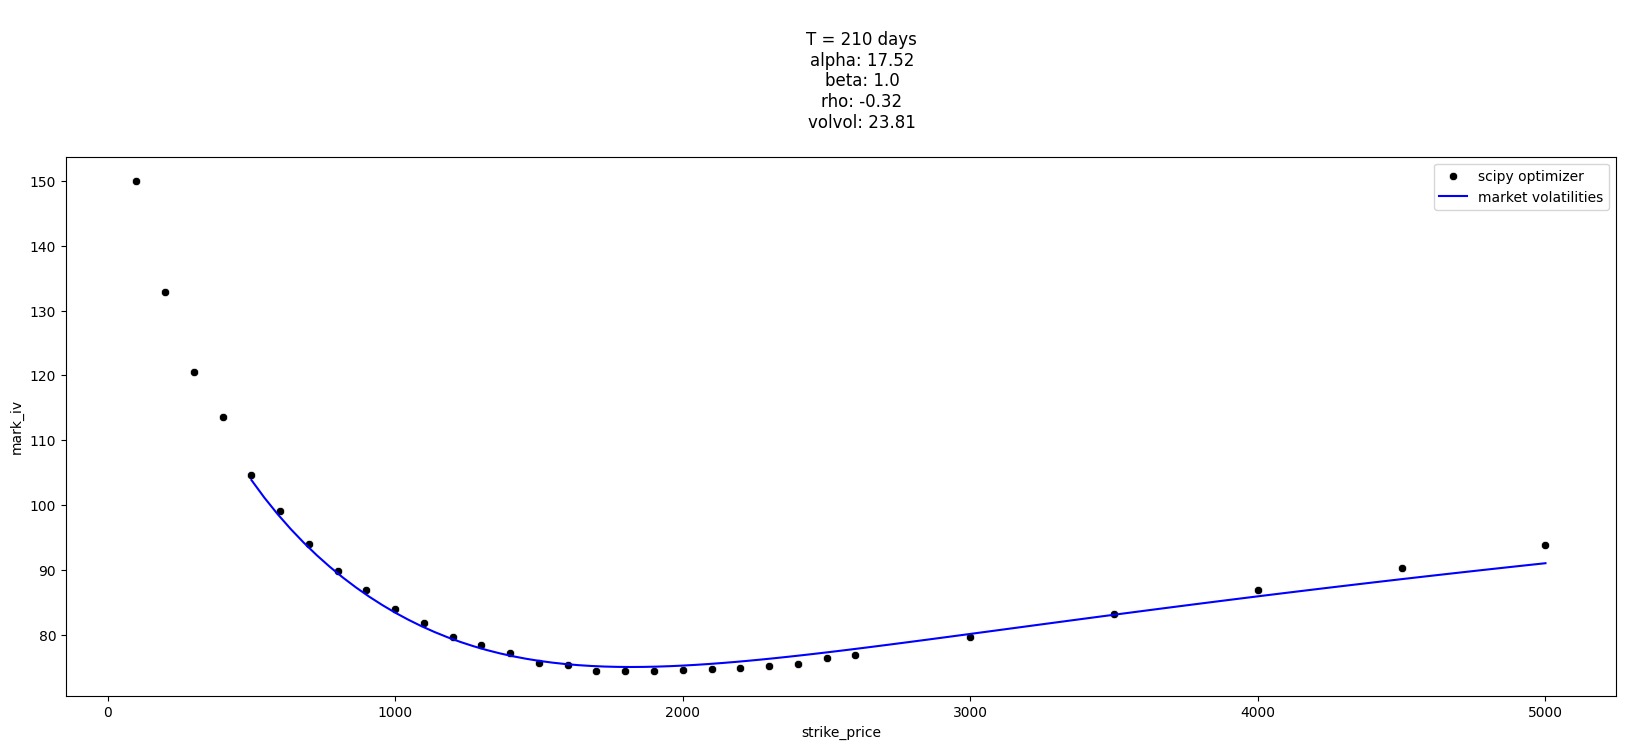

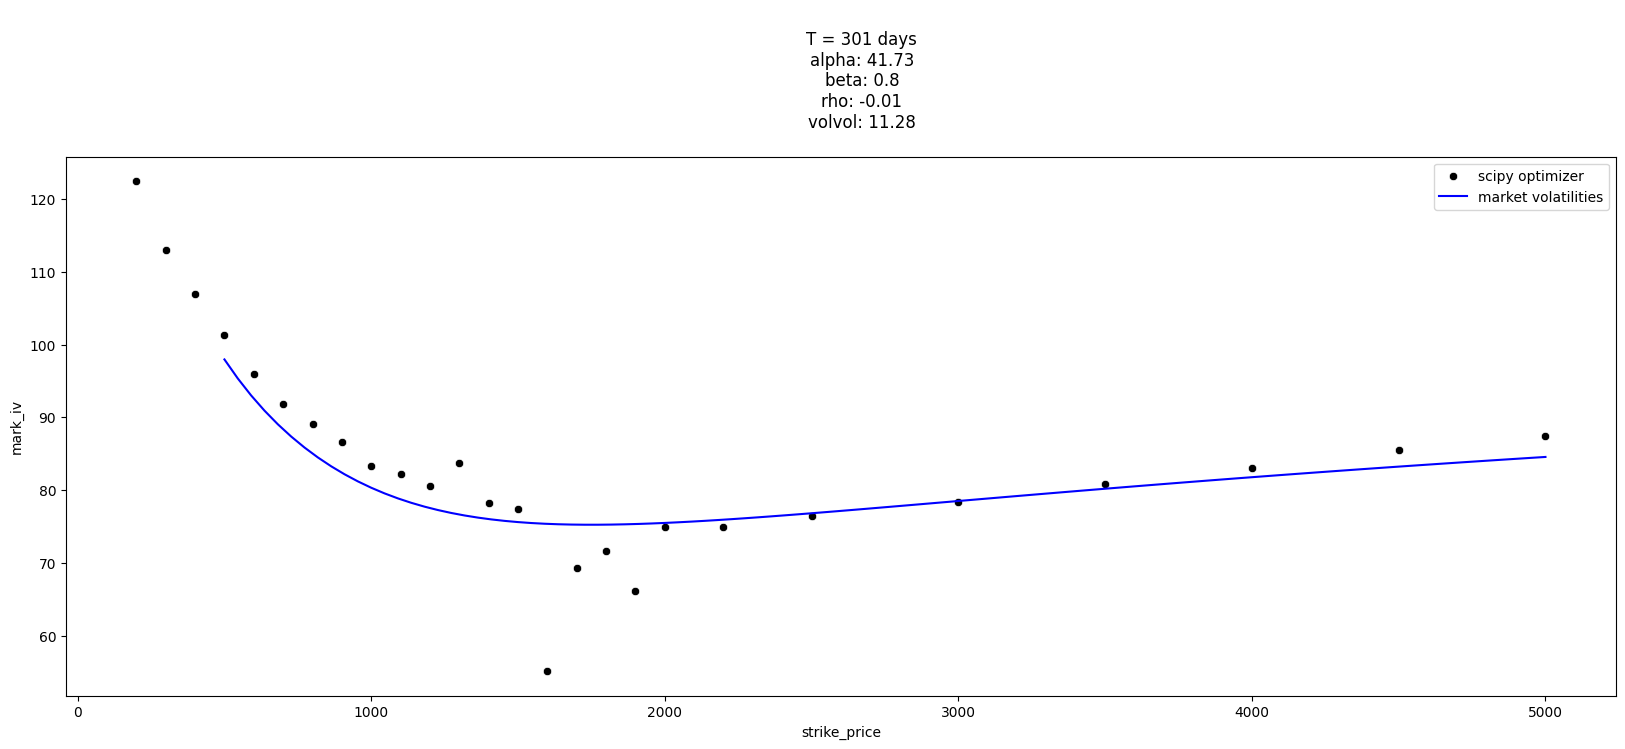

In [12]:
# see the params depending on expiration date on one tick
list_of_vols = []
alphas = []
betas = []
rhos = []
vs = []
Ts = []
expirations = call.expiration.unique()
for expiration in expirations:
    # count beta on each expiration separately 
    beta = find_beta_for_expiration(data[data["expiration"] == expiration])
    # select onle for given expiration
    call_ = call[call.expiration == expiration]
    put_ = put[put.expiration == expiration]
    # only out of the money
    cc = call_[call_["strike_price"]>=call_["underlying_price"]]
    pp = put_[put_["strike_price"]<=put_["underlying_price"]]
    dff = pd.concat([cc, pp])
    dff = dff[dff["strike_price"]<=5000]
    # calibrate with found beta
    sabr = SABR(dff, beta=beta)
    vols, alpha, beta, rho, v, T = sabr.run()
    list_of_vols.append(vols)
    alphas.append(alpha)
    betas.append(beta)
    rhos.append(rho)
    vs.append(v)
    Ts.append(T)

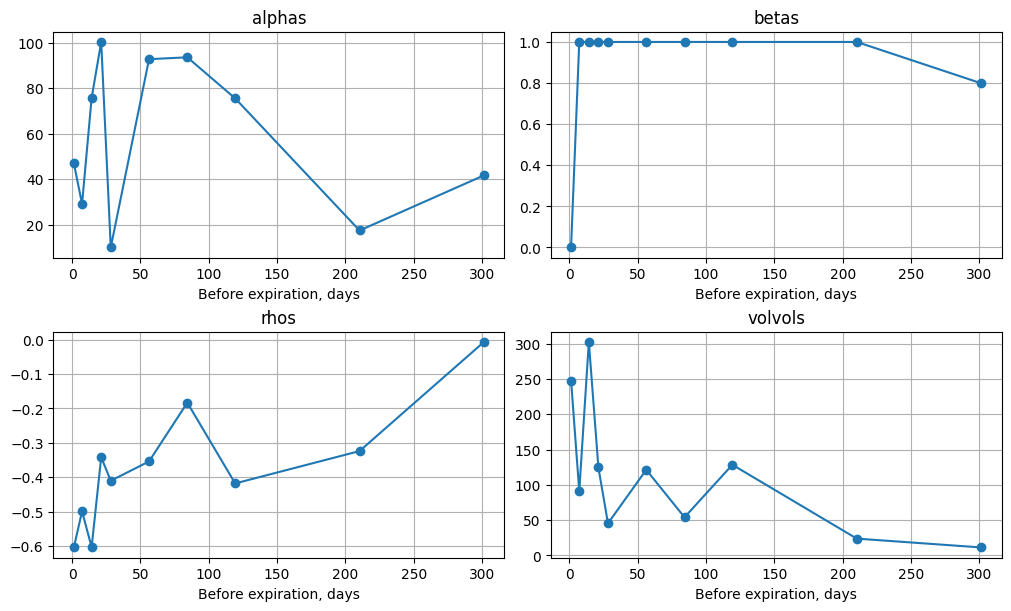

In [15]:
Ts_days = np.array(Ts)*365
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
x_axis_name = 'Before expiration, days'
axs[0, 0].plot(Ts_days, alphas, 'o', ls='-')
axs[0, 0].set_xlabel(x_axis_name)
axs[0, 0].set_title("alphas")
axs[0, 0].grid()

axs[0, 1].plot(Ts_days, betas, 'o', ls='-')
axs[0, 1].set_xlabel(x_axis_name)
axs[0, 1].set_title("betas")
axs[0, 1].grid()

axs[1, 0].plot(Ts_days, rhos, 'o', ls='-')
axs[1, 0].set_xlabel(x_axis_name)
axs[1, 0].set_title("rhos")
axs[1, 0].grid()

axs[1, 1].plot(Ts_days, vs, 'o', ls='-')
axs[1, 1].set_xlabel(x_axis_name)
axs[1, 1].set_title("volvols")
axs[1, 1].grid()


In [16]:
x, y, z = np.linspace(500, 5000, 100), days, np.array(list_of_vols)
sh_0, sh_1 = z.shape
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), 
                 )

fig.update_layout(title='Volatility surface', autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                 scene=dict(
        xaxis_title='Strike, $',
        yaxis_title='Maturity, days',
        zaxis_title='Volatility',
    )
                  
                 )
fig.show()